In [2]:
!pip install numpy
!pip install pandas


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [4]:
import pandas as pd

df = pd.read_csv("../sp500_ohlcv_2005_2025_2.csv")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2531599 entries, 0 to 2531598
Data columns (total 7 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Date    object 
 1   Ticker  object 
 2   Open    float64
 3   High    float64
 4   Low     float64
 5   Close   float64
 6   Volume  float64
dtypes: float64(5), object(2)
memory usage: 135.2+ MB


1) caractérisation des les distributions brutes :

Moyenne, médiane, min, max, écart-type de chaque variable (Open, High, Low, Close, Volume)

In [9]:
df[["Open", "Close", "High", "Low"]].describe()

,Open,Close,High,Low
count,2.289341e+06,2.289341e+06,2.289341e+06,2.289341e+06
mean,7.954547e+01,7.955652e+01,8.045225e+01,7.862208e+01
std,1.956153e+02,1.956711e+02,1.979174e+02,1.933779e+02
min,1.300000e-01,1.290000e-01,1.317140e-01,1.272860e-01
25%,2.043000e+01,2.043247e+01,2.067988e+01,2.016952e+01
50%,3.990766e+01,3.991722e+01,4.034133e+01,3.946571e+01
75%,8.205830e+01,8.206667e+01,8.293934e+01,8.114484e+01
max,9.914170e+03,9.924400e+03,9.964770e+03,9.794000e+03


on a un écart type bien plus important pour les colonnes High et Low que pour les colonnes Close et Open. Cela découle de la propriété suivante en statistique : Les maxima et minima d’une distribution ont mécaniquement une variance plus élevée que des valeurs prises à des instants fixes.

En effet, l’écart-type sensiblement plus élevé des colonnes High et Low par rapport à Open et Close s’explique par le fait que High et Low représentent des extrêmes intrajournaliers, beaucoup plus sensibles aux fluctuations temporaires du marché. À l'inverse, Open et Close capturent uniquement le prix à des instants fixes, ce qui réduit mécaniquement leur dispersion. Cela indique une volatilité intraday significative, très supérieure à la volatilité perçue via les seuls prix d’ouverture et de clôture.

2) calcul du ratio High/Low moyen

In [10]:
df["HL_ratio"] = df["High"] / df["Low"]

df["HL_ratio"].describe()

count    2.289341e+06
mean     1.025157e+00
std      2.092144e-02
min      1.000000e+00
25%      1.013842e+00
50%      1.019825e+00
75%      1.029554e+00
max      4.150000e+00
Name: HL_ratio, dtype: float64

Le High est en moyenne 2.52 % au-dessus du Low, donc la volatilité intraday moyenne ≈ 2.52 %.

L’analyse du ratio High/Low, défini comme HL=High/Low, révèle une amplitude intraday moyenne de 2.52 %, avec une médiane de 1.98 %. Cela montre qu'une action “typique” du S&P 500 fluctue d’environ 2 % entre son plus bas et son plus haut au cours d’une même séance. Les trois quart des observations présentent un range inférieur à 3 %, ce qui suggère une distribution relativement stable des fluctuations intrajournalières. Quelques valeurs extrêmes (max = 4.15) reflètent des événements atypiques ou des anomalies de marché. De manière générale, ces statistiques confirment l’existence d’une volatilité intraday significative au sein du S&P 500.

3) Distribution des rendements

In [12]:
df['Return'] = df.groupby('Ticker')['Close'].pct_change(fill_method=None)

df['Return'].describe()

count    2.288841e+06
mean     6.841147e-04
std      2.188942e-02
min     -6.079079e-01
25%     -8.476903e-03
50%      6.342769e-04
75%      9.789199e-03
max      1.023578e+00
Name: Return, dtype: float64

In [14]:
from scipy.stats import skew, kurtosis

sk = skew(df['Return'].dropna())
ku = kurtosis(df['Return'].dropna(), fisher=True)  # fisher=True → kurtosis de 0 = normale

print("Skewness :", sk)
print("Kurtosis :", ku)


Skewness : 0.49957317328765155
Kurtosis : 30.816410294619608


Les rendements quotidiens présentent une asymétrie positive (skewness ≈ 0.5), indiquant que des journées exceptionnellement haussières sont plus fréquentes que des journées exceptionnellement baissières lorsqu’on observe les actions individuellement.

La kurtosis des rendements est extrêmement élevée (≈ 31), ce qui indique des queues très épaisses. Cela reflète la présence d’un grand nombre de mouvements extrêmes dans l’ensemble des actions du S&P 500, notamment lors de crises (2008, COVID-2020), de releases de résultats, de nouvelles sectorielles, etc. La distribution est très éloignée d’une loi normale.

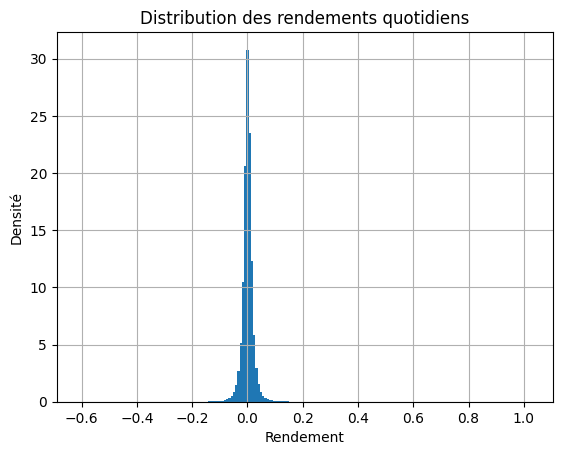

In [13]:
import matplotlib.pyplot as plt

df['Return'].dropna().hist(bins=200, density=True)
plt.title("Distribution des rendements quotidiens")
plt.xlabel("Rendement")
plt.ylabel("Densité")
plt.show()


En zoomant sur la masse centrale

<Axes: >

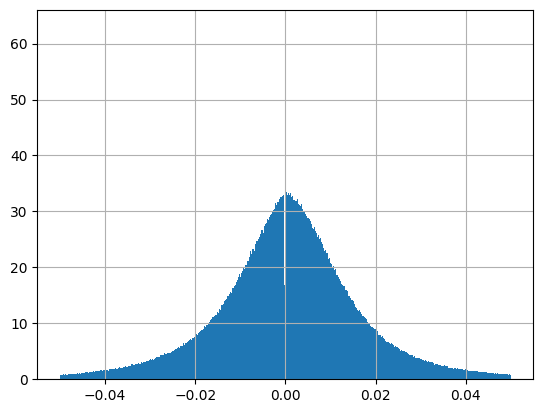

In [15]:
df['Return'].dropna().hist(bins=500, density=True, range=(-0.05, 0.05))

L’histogramme des rendements quotidiens (zoomé entre –5 % et +5 %) met en évidence plusieurs propriétés caractéristiques des séries financières :
(i) une concentration très forte autour de 0 %, traduisant de petites variations la majorité du temps ;
(ii) des queues épaisses visibles même à l’intérieur de ce zoom, cohérentes avec la kurtosis élevée (≈ 30.8) ;
(iii) une asymétrie légère mais perceptible vers les rendements positifs, en accord avec la skewness positive (≈ 0.5).

In [21]:
rho = df.groupby("Ticker")["Return"].apply(lambda x: x.autocorr(lag=1))
rho.describe()


count    500.000000
mean      -0.041916
std        0.044978
min       -0.184419
25%       -0.067962
50%       -0.039536
75%       -0.013702
max        0.119523
Name: Return, dtype: float64

L’autocorrélation au lag 1 des rendements individuels est en moyenne légèrement négative (≈ –0.04), avec une dispersion relativement faible. Cela indique une très légère mean reversion à un jour (un rendement positif aujourd’hui tend à être suivi d’un rendement négatif demain (et inversement)), généralement attribuée à des effets microstructurels. La magnitude reste très faible, ce qui est conforme à l’hypothèse d’efficience : les prix intègrent instantanément toute l’information disponible, ainsi, le prix d’aujourd’hui n’aide pas à prédire le prix de demain,les rendements passés ne permettent pas de prédire de manière exploitable les rendements futurs.